## Statistical Significance Test in A/B testing

Using simulated experiment data for a web site A/B test. In the experiment, we're testing the change in layout of a product information page to see if this affects the proportion of people who click on a button to go to the download page. This experiment has been designed to have a cookie-based diversion, and we record two things from each user: which page version they received, and whether or not they accessed the download page during the data recording period. 

We have 999 samples. 0 in the condition column denotes a control participant while a 1 denotes the experimental group. A 1 in the 'click' column specifies if the user clicked on the download.

First, I do a hypothesis test on the proportion of visitors assigned to our conditions to make sure it looks good.

mean = np and variance = npq 

In [2]:
# import packages

import numpy as np
import pandas as pd
import scipy.stats as stats
from statsmodels.stats import proportion as proptests
import random

import seaborn as sns
import matplotlib.pyplot as plt


In [3]:
data = pd.read_csv('data\statistical_significance_data.csv')
print(data.head(10))
print(data.shape)

data['condition'].value_counts()

   condition  click
0          1      0
1          0      0
2          0      0
3          1      1
4          1      0
5          1      0
6          0      0
7          1      1
8          0      0
9          1      0
(999, 2)


1    508
0    491
Name: condition, dtype: int64

### Hypothesis test on number of visitors assigned to each group

According to the condition column above 491 visitors have been assigned to the control group and 508 of the visitors have been assigned to the experimental group.

In this first exercise I compute the p value to give a probability of getting such a distribution. I hope to see a larger p-value, insufficient evidence to reject the null hypothesis.

#### Taking a Simulation Approach

In [4]:
num_trials = 500_000 #number of binomial samples to generate
num_obs = 999

In [5]:
#create the binomial samples
samples_list = []
for i in range(num_trials):
    randlist = np.random.randint(0,2,num_obs)
    samples_list.append(randlist.sum())
samples = np.array(samples_list)
    

*Alternatively the following numpy function could have been used to generate the samples:*

    samples = np.random.binomial(num_obs, 0.5, num_trials)

Text(0.5, 1.0, 'Histogram of trial results with a fitted normal PDF overlayed')

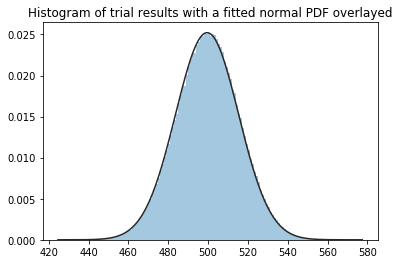

In [6]:
ax = sns.distplot(samples, bins=np.linspace(440,560,121), kde=False, norm_hist=True, fit=stats.norm )
ax.set_title("Histogram of trial results with a fitted normal PDF overlayed")

*for illustration of what the distrubution would look like, I rerun the above experiment with less trials and plot again*

Text(0.5, 1.0, 'Rerun of the above experiment with fewer trials')

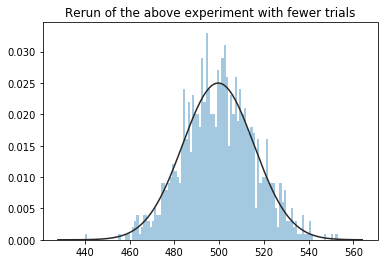

In [7]:
num_trials_rerun = 1000
samples_rerun = np.random.binomial(num_obs, 0.5, num_trials_rerun)
ax = sns.distplot(samples_rerun, bins=np.linspace(440,560,121), kde=False, norm_hist=True, fit=stats.norm )
ax.set_title("Rerun of the above experiment with fewer trials")

In [8]:
#For clarity in the following eqn:
num_control = 491
num_experiment = 508

#Calculate which of our trials lie outside of our trial in terms of likelihood
less_likely_trials = np.logical_or(samples <= num_control, samples >=num_experiment )
less_likely_trials.mean()

0.612572

#### Taking a Quasi-Simulation Approach

Here I stated to try to compute the P-score by taking the simulated sample data and computing a mean and standard deviation from that data. however I realised that since the distribution was known to be binonial, we can use the population mean and standard deviation which saves times, simplifies the code, is more accurate and is less error prone since we can avail of scipy or numpy functions.

In [9]:
print(np.std(samples))
print(np.mean(samples))

15.82014240711834
499.475136


In [10]:
t = ((num_experiment-0.5) - np.mean(samples))/np.std(samples)

In [11]:
p_score = stats.norm.sf(t)

In [12]:
p_score*2

0.611975125244546

#### Taking an Analysis Approach

In [10]:
p = 0.5
num_control = 491

#Calculate the standard deviation. Remember variance of a binomial distribution is n*p*(1-p)
sd = np.sqrt(p * (1-p) * num_obs)

#Calculate the z score
mean = p * num_obs
z = ((num_control + 0.5) - mean) / sd
print("Z-Score by Analysis:", z)

#convert to p score
print("P-Score by Analysis: ", 2 * stats.norm.cdf(z))

Z-Score by Analysis: -0.5062175977346661
P-Score by Analysis:  0.6127039025537114


*Or simply avail of the `binom_test` function in scipy.stats:*

    p_score = stats.binom_test(num_control, num_obs, p)

### Hypothesis test on the evaluation metric

The evaluation metric in this case is the click-through rate which is recorded in the click column in our dataset.

In [13]:
#For clarity in the following eqns:
num_control = 491
num_experiment = 508

In [14]:
p_con= data.groupby('condition').mean()['click'][0]
p_exp = data.groupby('condition').mean()['click'][1]
p_tot = data['click'].mean()


#### Taking an Analysis Approach

*Formula for calculating the standard error of the difference between independent sample means when the sample sizes are roughly the same: (Note that this is not relevent here as we are working with propportions)*

$$s_{\hat{x}1-\hat{x}2} = \sqrt{s_{\hat{x}1}^2 + s_{\hat{x}2}^2}$$

*where:*

*$s_{\hat{x}1}$ is the standard error of the mean for the first sample*  
*$s_{\hat{x}2}$ is the standard error of the mean for the second sample*

*Formula for calculating the standard error of the difference between proportions:*

$$\sqrt{\frac{\hat{p}_{1}*(1-\hat{p}_{1})}{n_{1}} + \frac{\hat{p}_{2}*(1-\hat{p}_{2})}{n_{2}} }$$ 

*The exercise here is to prove that the sample proportions are different (i.e. $p_{1} - p_{2} = 0$). This is a null hypothesis test. So the null hypothesis test assumes that that the distrubtions are the same and therefore we can pool the proportions together to be used in the standard error:*

$$\sqrt{p(1-p)(\frac{1}{n_{1}} + \frac{1}{n_{2}})}$$

*where $p$ is the pooled proportion*

*We use the estimated standard error to calculate the Z-test statistic:*

$$Z = \frac{statistic - parameter}{Standard Error}$$

Since p1 − p2 = 0 in the null hypothesis, the Z-test statistic simplifies to the following:

$$Z = \frac{(p_{1} - p_{2})-0}{\sqrt{p(1-p)(\frac{1}{n_{1}} + \frac{1}{n_{2}})}}$$

In [17]:
#Calculate the standard deviation.
se = np.sqrt(p_tot*(1-p_tot)*(1/num_control + 1/num_experiment))

#Calculate the z score
z  =  (p_exp - p_con) / se
print("Z-Score by Analysis:", z)

#convert to p score
print("P-Score by Analysis: ", 1 - stats.norm.cdf(z))


Z-Score by Analysis: 1.7571887396196666
P-Score by Analysis:  0.039442821974613684


#### Taking a Simulation Approach

In [ ]:
num_trials = 100_000

samples = np.random.binomial(num_obs, 0.5, num_trials)